In [1]:
%matplotlib inline

import numpy as np
import power_laws
import matplotlib.colors
import seaborn
import pandas as pd
import rubisco_data

from scipy import stats
from matplotlib import pyplot as plt

In [2]:
# Load the data from Excel, remove data points that are not comparable.
# raw_kin_df is everything in the file, kin_df is the subset with all relevant kinetic data.
raw_kin_df, kin_df = rubisco_data.load_rubisco_data()

# Subset the data in various ways for future use
raw_kin_df, savir_df, nonsavir_df = rubisco_data.filter_data(raw_kin_df)

# Merge multiple measurements of the same organism by taking the median value.
merged_kin_df = rubisco_data.merge_organisms(raw_kin_df)

# Group by RuBisCO form
grouped_form = merged_kin_df.groupby('isoform')

# Markers we use for plotting below.
markers = 'o><^dsphH*'

cnames = ["windows blue", "amber", "greyish brown", "dusty purple", "dusty teal", "dusty red", ]
named_colors = seaborn.xkcd_palette(cnames)

In [3]:
print(raw_kin_df.shape[0], 'total WT RuBisCOs')
print(raw_kin_df.species.unique().size, 'total unique species')
print(kin_df.shape[0], 'RuBisCOs with all core kinetic data measured')
print(merged_kin_df.shape[0], 'data points post-merge')

380 total WT RuBisCOs
304 total unique species
208 RuBisCOs with all core kinetic data measured
305 data points post-merge


In [4]:
# kon_O vs kon_C
kon_Os = np.log(merged_kin_df.kon_O)
kon_Cs = np.log(merged_kin_df.kon_C)

print('Whole dataset correlation')
r, p = power_laws.log_pearsonr(kon_Os, kon_Cs)
print('Log-scale linear regression R = %.2f, P = %.2g' % (r, p))
print('Spearman rank correlation R = %.2f, P = %.2g' % power_laws.log_spearmanr(kon_Os, kon_Cs))

fIs = merged_kin_df[merged_kin_df.isoform == '1']
kon_Os = np.log(fIs.kon_O)
kon_Cs = np.log(fIs.kon_C)

print('FI dataset correlation')
r, p = power_laws.log_pearsonr(kon_Os, kon_Cs)
print('Log-scale linear regression R = %.2f, P = %.2g' % (r, p))
print('Spearman rank correlation R = %.2f, P = %.2g' % power_laws.log_spearmanr(kon_Os, kon_Cs))

kon_Os = np.log(savir_df.kon_O)
kon_Cs = np.log(savir_df.kon_C)

print('Savir correlation')
r, p = power_laws.log_pearsonr(kon_Os, kon_Cs)
print('Log-scale linear regression R = %.2f, P = %.2g' % (r, p))
print('Spearman rank correlation R = %.2f, P = %.2g' % power_laws.log_spearmanr(kon_Os, kon_Cs))

Whole dataset correlation
Log-scale linear regression R = 0.66, P = 2.9e-24
Spearman rank correlation R = 0.85, P = 1.4e-52
FI dataset correlation
Log-scale linear regression R = 0.94, P = 5.5e-87
Spearman rank correlation R = 0.93, P = 2.5e-80
Savir correlation
Log-scale linear regression R = 0.58, P = 0.02
Spearman rank correlation R = 0.48, P = 0.058


In [5]:
# Regress on F1 data to get best fit. 
fIs = merged_kin_df[merged_kin_df.isoform == '1']
kon_Os = np.log(fIs.kon_O)
kon_Cs = np.log(fIs.kon_C)

exp_F1, pre_F1, r_F1 = power_laws.fit_power_law_odr(kon_Os, kon_Cs, unit_exp=False)
print(exp_F1, pre_F1, r_F1)

1.038498991072923 119.06099984746886 0.9430088292160368


In [6]:
# Bootstrapped regression over the FI rubiscos

# konC = vC/KC (both measured)
# konO = vO/KO (vO not measured)
# S = vC/KC / (vO/KO)
# Therefore,
# vO = vC/KC / (S/KO) and
# konO = vC/KC / (S/KO) / (KO) = vC/(S KC)

all_FIs = merged_kin_df[merged_kin_df.isoform == '1']
fraction = 0.9
tot = all_FIs.kon_C.size
subset_size = int(fraction * tot)

runs = 10000
exponents = []
prefactors = []
prefactors_1 = []
rvals = []
for _ in range(runs):
    idxs = np.random.choice(tot, subset_size)
    subset = all_FIs.iloc[idxs]
    
    # Make kcatC/KC sample
    vC_vals = subset.vC
    KC_vals = subset.KC
    konC_vals = vC_vals / KC_vals

    # kcatO/KO sample
    S_vals = subset.S
    konO_vals = vC_vals / KC_vals / S_vals
    
    log_konC = np.log(konC_vals)
    log_konO = np.log(konO_vals)
    
    # Fit a power law.
    exp, pre, rval = power_laws.fit_power_law_odr(log_konO, log_konC)
    exponents.append(exp)
    prefactors.append(pre)
    rvals.append(rval)
    
    # Fit a power law with exp = 1.0
    exp, pre, _ = power_laws.fit_power_law_odr(log_konO, log_konC, unit_exp=True)
    prefactors_1.append(pre)

In [7]:
conf_range = [2.5, 97.5]
pre_interval = np.percentile(prefactors, conf_range)
exp_interval = np.percentile(exponents, conf_range)
rs_interval = np.percentile(rvals, conf_range)
pre1_interval = np.percentile(prefactors_1, conf_range)

print('exponent 95% CI', exp_interval)
print('prefactor 95% CI', pre_interval)
print('R 95% CI', rs_interval)
print('prefactor 95% CI assuming exp=1.0', pre1_interval)


exponent 95% CI [0.93467786 1.12312945]
prefactor 95% CI [ 63.03772676 200.49079997]
R 95% CI [0.8726464  0.95168817]
prefactor 95% CI assuming exp=1.0 [91.2281313  97.15814626]


[ 63.03772676 200.49079997]
[0.93467786 1.12312945]


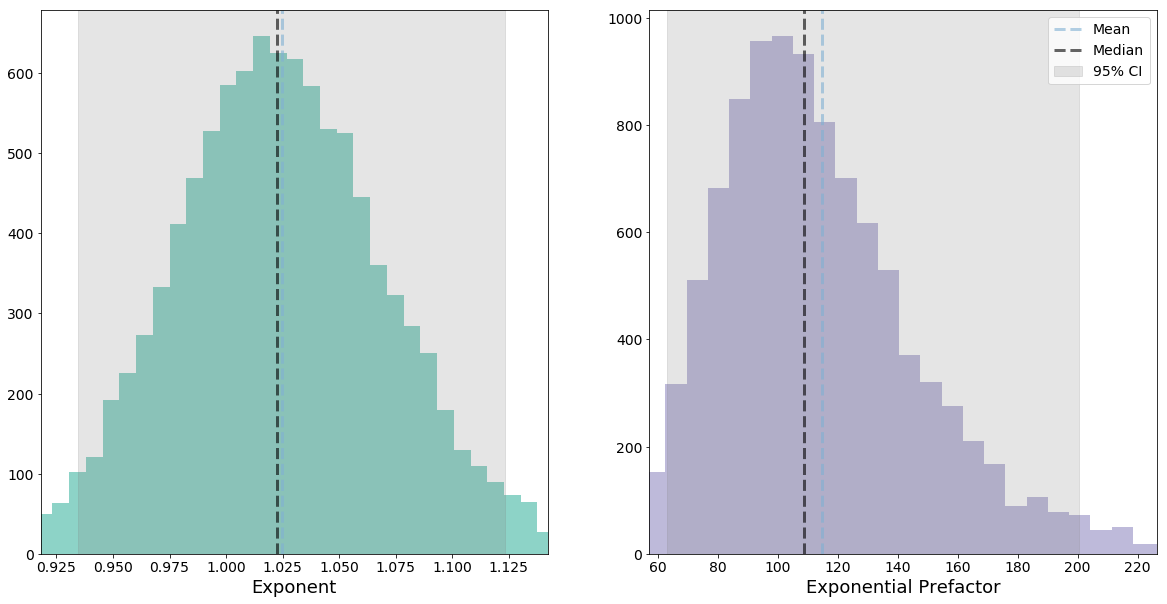

In [8]:
power_laws.plot_bootstrapped_range(exponents, prefactors)

In [9]:
# Regress on savir data to get previous fit. 
# NOTE: 1. Savir drops the FII Rubiscos for this fit, I think. Unclear from text if he dropped both or one.
# NOTE: 2. Can't reproduce his exponent of 0.5. I get 0.77. 
savir_FI = savir_df[savir_df.isoform == '1']

konOs = np.log(savir_FI.kon_O)
konCs = np.log(savir_FI.kon_C)
exp_savir, pre_savir, r = power_laws.fit_power_law_odr(konOs, konCs, unit_exp=False)
print(exp_savir, pre_savir, r)

1.2943950250179748 452.41659000481104 0.840176568310546


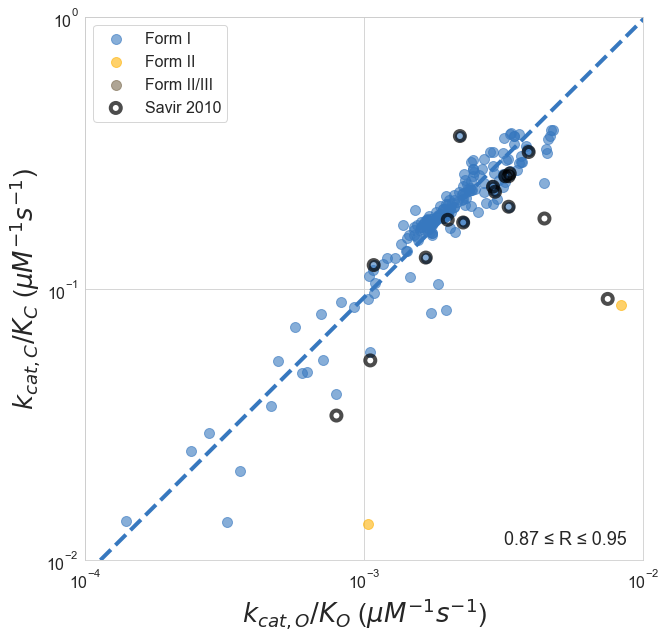

In [10]:
# Mechanistic proposal #2 from Savir - k_onC vs k_onO
figure = plt.figure(figsize=(10,10))
seaborn.set_style('whitegrid')
colors = seaborn.color_palette("BrBG", 10)

plt.xscale('log')
plt.yscale('log')

groups = {'1': 'I', 
          '2': 'II',
          '2_3': 'II/III', 
          '3': 'III'}

for i, (group, gdf) in enumerate(grouped_form):
    if group == '3':
        continue
    label = 'Form %s' % groups[group]
    c = matplotlib.colors.rgb2hex(named_colors[i])
    plt.scatter(gdf.kon_O, gdf.kon_C,  c=c, s=100, label=label, alpha=0.6)

# Plot our regression and CI
xs = np.arange(1e-4, 2e-2, 0.01)
c = matplotlib.colors.rgb2hex(named_colors[0])
power_laws.plot_bootstrapped_ci(xs, exponents, prefactors, figure=figure, color=c,
                                lw=4, plot_range=False)

# Savir power law, inferred
#plt.plot(xs, np.power(xs, exp_savir)*pre_savir, c='grey', lw=2, ls='--')

# Show savir data with an outline
plt.scatter(savir_df.kon_O, savir_df.kon_C, c='None', edgecolors='k',
            linewidths=4, s=100, label='Savir 2010', alpha=0.7, zorder=10)
plt.text(0.75, 0.03, u'%.2f ≤ R ≤ %.2f' % (rs_interval[0], rs_interval[1]), 
         transform=figure.axes[0].transAxes, fontsize=18)

plt.legend(loc=2, fontsize=16, frameon=True)
plt.xlabel('$k_{cat,O} / K_O$ ($\mu M^{-1} s^{-1}$)', fontsize=26)
plt.ylabel('$k_{cat,C} / K_C$ ($\mu M^{-1} s^{-1}$)', fontsize=26)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.xlim(1e-4, 1e-2)
plt.ylim(1e-2, 1)

plt.savefig('fig7/fig7_konC_konO_FI.png', dpi=600)
plt.savefig('fig7/fig7_konC_konO_FI.svg')

plt.show()

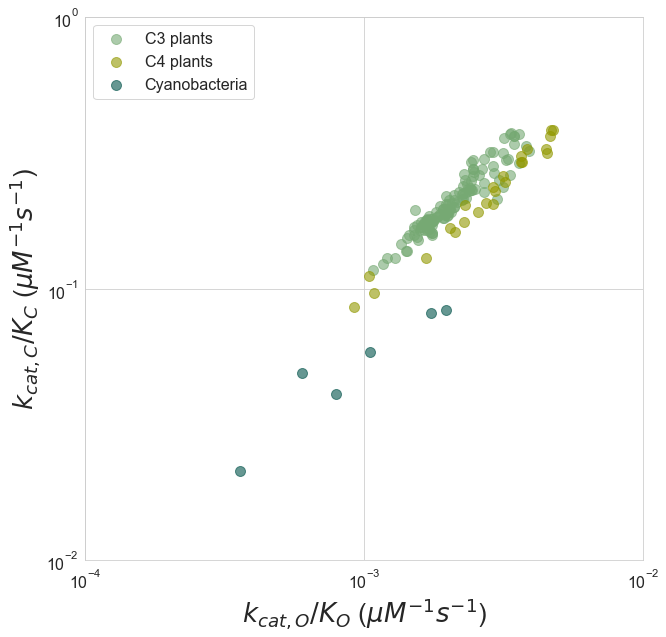

In [11]:
# Mechanistic proposal #1 from Savir - Vc vs. k_onC color by isoform
figure = plt.figure(figsize=(10,10))
seaborn.set_style('whitegrid')

plt.xscale('log')
plt.yscale('log')

F1_data = merged_kin_df[merged_kin_df.isoform == '1']
F2_data = merged_kin_df[merged_kin_df.isoform == '2']
F23_data = merged_kin_df[merged_kin_df.isoform == '2_3']

group_mapping = {'C3 plants': 'C3 plants',
                 'Cyanobacteria': 'Cyanobacteria',
                 'C4 plants': 'C4 plants',
                 # Omitting the clades below since there is limited data 
                 # Figure is easier to read this way
                 #'C3-C4 plants': 'C3-C4 plants',
                 #'Green algae': 'Green algae',
                 #'Red algae': 'Red algae',
                 #'Alphaproteobacteria': 'Proteobacteria',
                 #'Betaproteobacteria': 'Proteobacteria',
                 #'Gammaproteobacteria': 'Proteobacteria',
                }
color_mapping = {
    'C3 plants': 'dusty green',
    'C3-C4 plants': 'very light brown',
    'C4 plants': 'pea soup',
    'Cyanobacteria': 'dark blue green',
    'Green algae': 'dusty teal',
    'Red algae': 'dusty red',
    'Proteobacteria': 'dusty rose',
    'Form II':  "amber", 
    'Form II/III': "greyish brown",
}
grouped_taxa = F1_data.set_index('taxonomy').groupby(group_mapping)

for i, (group, gdf) in enumerate(grouped_taxa):   
    cname = color_mapping[group]
    c = seaborn.xkcd_rgb[cname]
    plt.scatter(gdf.kon_O, gdf.kon_C, c=[c], s=100, label=group, alpha=0.6)
    

plt.legend(loc=2, fontsize=16, frameon=True)
plt.xlabel('$k_{cat,O} / K_O$ ($\mu M^{-1} s^{-1}$)', fontsize=26)
plt.ylabel('$k_{cat,C} / K_C$ ($\mu M^{-1} s^{-1}$)', fontsize=26)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.xlim(1e-4, 1e-2)
plt.ylim(1e-2, 1)

plt.savefig('fig7/fig7_konC_konO_FI_by_group.png', dpi=600)
plt.savefig('fig7/fig7_konC_konO_FI_by_group.svg')

plt.show()

In [12]:
all_FIs = merged_kin_df[merged_kin_df.isoform == '1']
konOs = np.log(all_FIs.kon_O)
konCs = np.log(all_FIs.kon_C)
print('Free exp')
print(power_laws.fit_power_law_odr(konOs, konCs, unit_exp=False))

print('exponent=1.0')
print(power_laws.fit_power_law_odr(konOs, konCs, unit_exp=True))

Free exp
(1.038498991072923, 119.06099984746886, 0.9430088292160368)
exponent=1.0
(1, 93.58899854825725, 0.9430088292160365)


In [13]:
for i, (group, gdf) in enumerate(grouped_taxa):   
    # Only use points that have data - bootstrapping will work right now.
    mask = gdf.kon_O.notnull() & gdf.kon_C.notnull()
    size = mask.sum()
    masked_gdf = gdf[mask]
    
    print(group)
    print('%d data points' % size)
    if size < 6:
        print('Not enough data')
        print()
        continue
        
    exps, pres, rs = power_laws.bootstrap_power_law_odr(masked_gdf.kon_O, masked_gdf.kon_C, rounds=1000)
    
    ci = 0.95
    ci_end = (1.0 - ci)/2.0
    conf_range = [100-100*ci_end, 100*ci_end]
    pre_interval = np.percentile(pres, conf_range)
    exp_interval = np.percentile(exps, conf_range)
    rs_interval = np.percentile(rs, conf_range)
    
    print('exponent 95% ci:', exp_interval)
    print('prefactor 95% ci:', pre_interval)
    print('pearson R 95% ci:', rs_interval)
    print()

C3 plants
120 data points
exponent 95% ci: [1.00483031 0.87208092]
prefactor 95% ci: [105.03668305  45.63958868]
pearson R 95% ci: [0.96309448 0.91813916]

C4 plants
24 data points
exponent 95% ci: [1.02117224 0.82572478]
prefactor 95% ci: [89.58245133 28.77281678]
pearson R 95% ci: [0.99416213 0.97119757]

Cyanobacteria
6 data points


/usr/local/lib/python3.6/site-packages/scipy/stats/stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/usr/local/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:116: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/usr/local/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:128: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


exponent 95% ci: [nan nan]
prefactor 95% ci: [nan nan]
pearson R 95% ci: [nan nan]



/usr/local/lib/python3.6/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
